<a href="https://colab.research.google.com/github/DianaDoosti/Introduction_to_AI_2025/blob/main/AI4031_MP1/Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Importing the data

In [150]:
# loading the dataset as a pandas data frame
url = "https://docs.google.com/spreadsheets/d/1ZS8Tumz9P9S5e5yI-5YAKNLEDihGhiSnEV46D3v1g0c/export?format=csv&gid=2079675061"
df = pd.read_csv(url, header=None)

# Organising the data frame and make it easier to work with
df = df.transpose()
df.columns = [f"feature_{i}" for i in range(df.shape[1])]
print(df.shape)
print(df.head())

(2000, 4)
   feature_0  feature_1  feature_2  feature_3
0        1.0       13.0    -3980.0    -3959.0
1        2.0       29.0    -3883.0    -4058.0
2        3.0       44.0    -3832.0    -4131.0
3        4.0       55.0        0.0    -4033.0
4        5.0       61.0    -3839.0    -4009.0


# **Section 1 : one dependent variable**

# step 1.1 : Visualizing the raw data

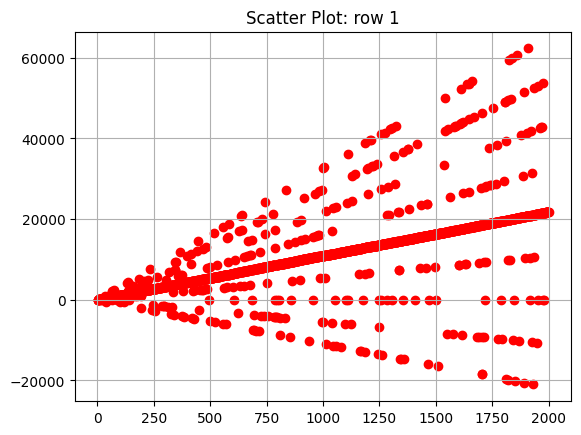

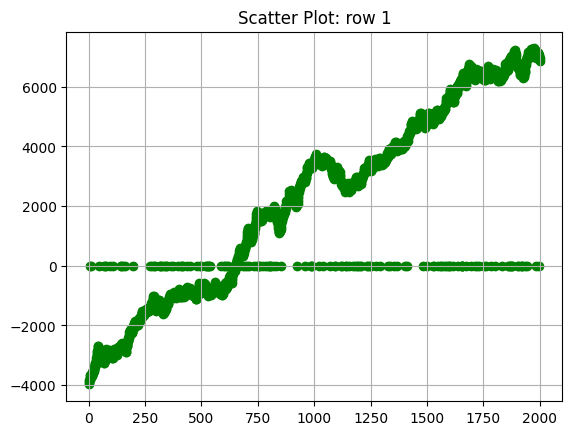

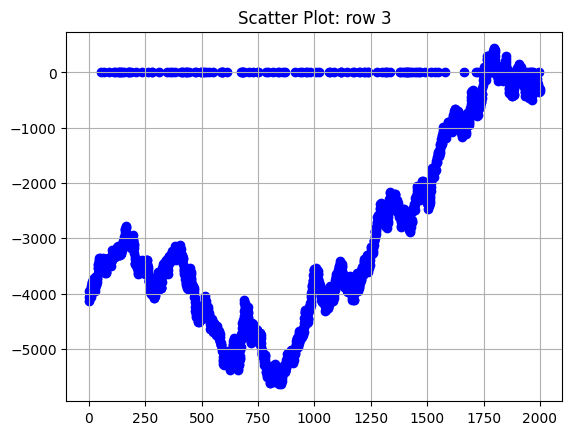

In [151]:
# plotting each row of the original dataset individualy

#plotting row 1
plt.scatter(df["feature_0"], df["feature_1"], color='red', label='Feature 1')
plt.title("Scatter Plot: row 1")
plt.grid(True)
plt.show()

#plotting row 1
plt.scatter(df["feature_0"], df["feature_2"], color='green', label='Feature 2')
plt.title("Scatter Plot: row 1")
plt.grid(True)
plt.show()

#plotting row 1
plt.scatter(df["feature_0"], df["feature_3"], color='blue', label='Feature 3')
plt.title("Scatter Plot: row 3")
plt.grid(True)
plt.show()

# step 1.2 : Data cleaning

In [152]:
# defining data cleaning functions :
# IQR Outlier Handling (Replace with neighbors' mean)
def replace_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for i in range(1, len(df[column]) - 1):
        if df[column][i] < lower_bound or df[column][i] > upper_bound:
            df[column][i] = np.mean([df[column][i-1], df[column][i+1]])  # Replace with mean of neighbors
    return df

#  Z-Score Outlier Handling (Replace with neighbors' mean)
def replace_zscore_outliers(df, column, threshold=0.2):
    z_scores = np.abs(zscore(df[column]))

    for i in range(1, len(df[column]) - 1):
        if z_scores[i] > threshold:
            df[column][i] = np.mean([df[column][i-1], df[column][i+1]])  # Replace with mean of neighbors
    return df

# Apply IQR and Z-score techniques
# cleaning row 1
df_iqr = replace_iqr_outliers(df.copy(), 'feature_1')
df_final = replace_zscore_outliers(df_iqr.copy(), 'feature_1')

# cleaning row 2
df_iqr_2 = replace_iqr_outliers(df.copy(), 'feature_2')
df_final_2 = replace_zscore_outliers(df_iqr.copy(), 'feature_2')

# cleaning row 3
df_iqr_3 = replace_iqr_outliers(df.copy(), 'feature_3')
df_final_3 = replace_zscore_outliers(df_iqr.copy(), 'feature_3')


**Visualizing raw and cleaned data**

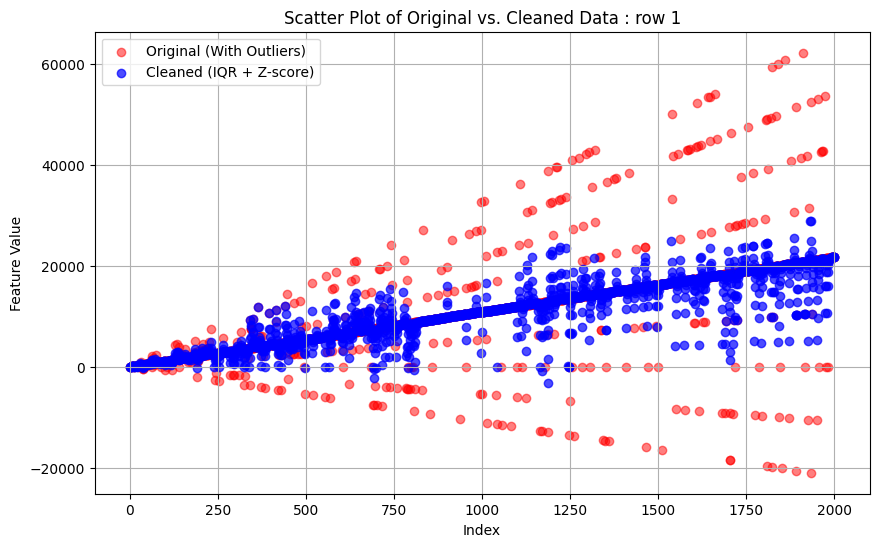

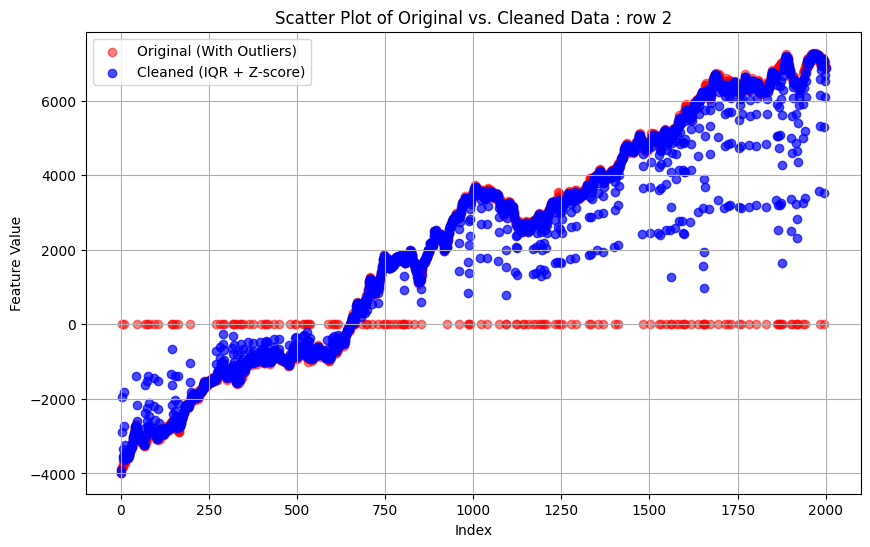

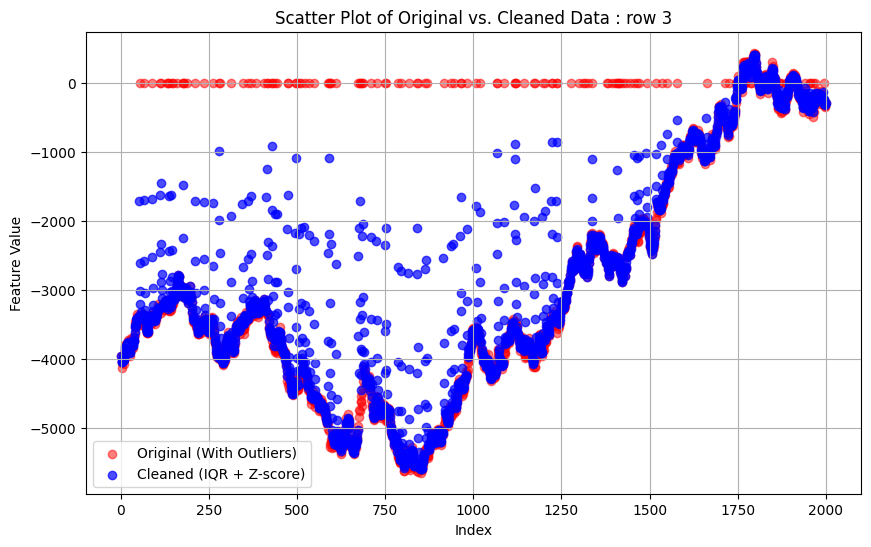

In [153]:
# Plot Original vs. Cleaned Data
# row 1
plt.figure(figsize=(10, 6))

# Original Data with Outliers (Red)
plt.scatter(df['feature_0'], df['feature_1'], color='red', alpha=0.5, label='Original (With Outliers)')

# Cleaned Data (Blue)
plt.scatter(df_final['feature_0'], df_final['feature_1'], color='blue', alpha=0.7, label='Cleaned (IQR + Z-score)')

# Labels and Legend
plt.xlabel("Index")
plt.ylabel("Feature Value")
plt.title("Scatter Plot of Original vs. Cleaned Data : row 1")
plt.legend()
plt.grid(True)
plt.show()

#row 2
plt.figure(figsize=(10, 6))

# Original Data with Outliers (Red)
plt.scatter(df['feature_0'], df['feature_2'], color='red', alpha=0.5, label='Original (With Outliers)')

# Cleaned Data (Blue)
plt.scatter(df_final_2['feature_0'], df_final_2['feature_2'], color='blue', alpha=0.7, label='Cleaned (IQR + Z-score)')

# Labels and Legend
plt.xlabel("Index")
plt.ylabel("Feature Value")
plt.title("Scatter Plot of Original vs. Cleaned Data : row 2")
plt.legend()
plt.grid(True)
plt.show()

#row 3
plt.figure(figsize=(10, 6))

# Original Data with Outliers (Red)
plt.scatter(df['feature_0'], df['feature_3'], color='red', alpha=0.5, label='Original (With Outliers)')

# Cleaned Data (Blue)
plt.scatter(df_final_3['feature_0'], df_final_3['feature_3'], color='blue', alpha=0.7, label='Cleaned (IQR + Z-score)')

# Labels and Legend
plt.xlabel("Index")
plt.ylabel("Feature Value")
plt.title("Scatter Plot of Original vs. Cleaned Data : row 3")
plt.legend()
plt.grid(True)
plt.show()

# step 1.3 : Linear regression from scratch

In [154]:
# making the models from scratch
# model for cost function 1(MSE)
class LinearRegressionMSE:
    def __init__(self, lr, n_iters):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# model for cost function 2(MAE)
class LinearRegressionMAE:
    def __init__(self, lr, n_iters):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iters):
                y_pred = np.dot(X, self.weights) + self.bias
                error = np.sign(y_pred - y)

                dw = (1 / n_samples) * np.dot(X.T, error)
                db = (1 / n_samples) * np.sum(error)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db


    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

**Applying and visualizing regression from scratch**

Row 1

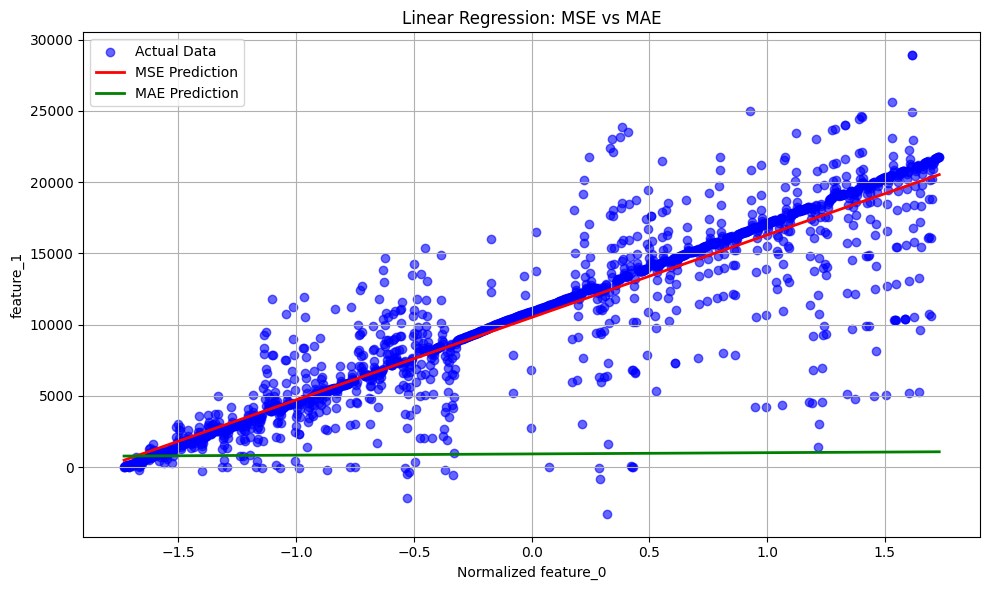

In [155]:
# Select independent variable (X) and dependent variable (y)
X = df[['feature_0']].values  # This selects feature_0
y = df_final['feature_1'].values  # This selects feature_1 as the dependent variable(cleaned)

# Normalize feature_0 using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This scales the feature

# MSE Model
model_mse = LinearRegressionMSE(lr=0.1, n_iters=10000)
model_mse.fit(X_scaled, y)
preds_mse = model_mse.predict(X_scaled)

# MAE Model
model_mae = LinearRegressionMAE(lr=0.1, n_iters=10000)
model_mae.fit(X_scaled, y)
preds_mae = model_mae.predict(X_scaled)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y, color='blue', label='Actual Data', alpha=0.6)
plt.plot(X_scaled, preds_mse, color='red', label='MSE Prediction', linewidth=2)
plt.plot(X_scaled, preds_mae, color='green', label='MAE Prediction', linewidth=2)

plt.xlabel('Normalized feature_0')  # Indicating that feature_0 has been normalized
plt.ylabel('feature_1')  # The dependent variable
plt.title('Linear Regression: MSE vs MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Row 2

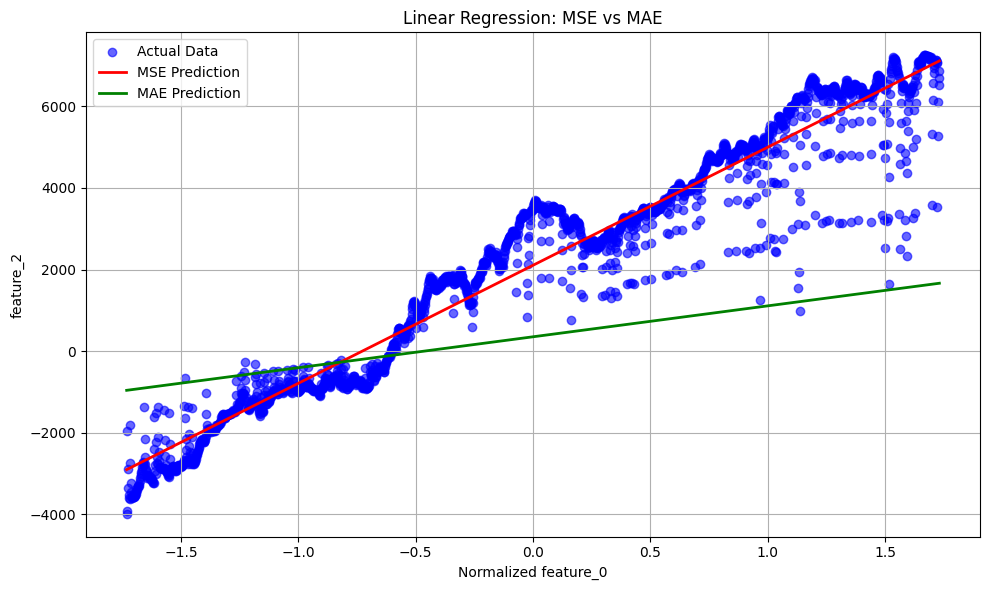

In [156]:
# Select independent variable (X) and dependent variable (y)
X = df[['feature_0']].values  # This selects feature_0
y = df_final_2['feature_2'].values  # This selects feature_2 as the dependent variable

# Normalize feature_0 using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This scales the feature

# MSE Model
model_mse = LinearRegressionMSE(lr=0.1, n_iters=10000)
model_mse.fit(X_scaled, y)
preds_mse = model_mse.predict(X_scaled)

# MAE Model
model_mae = LinearRegressionMAE(lr=0.1, n_iters=10000)
model_mae.fit(X_scaled, y)
preds_mae = model_mae.predict(X_scaled)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y, color='blue', label='Actual Data', alpha=0.6)
plt.plot(X_scaled, preds_mse, color='red', label='MSE Prediction', linewidth=2)
plt.plot(X_scaled, preds_mae, color='green', label='MAE Prediction', linewidth=2)

plt.xlabel('Normalized feature_0')  # Indicating that feature_0 has been normalized
plt.ylabel('feature_2')  # The dependent variable
plt.title('Linear Regression: MSE vs MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Row 3

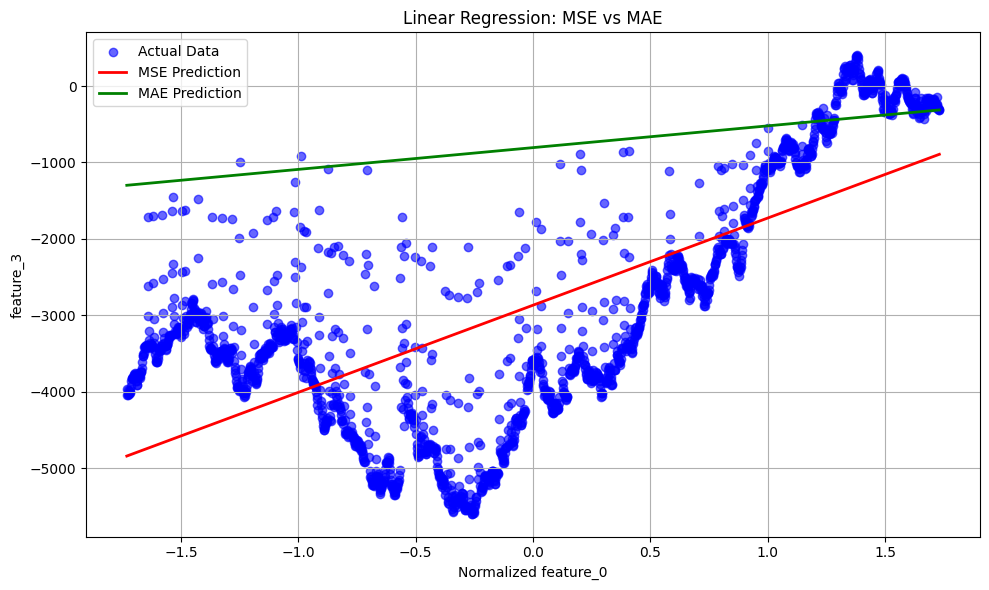

In [157]:
# Select independent variable (X) and dependent variable (y)
X = df[['feature_0']].values  # This selects feature_0
y = df_final_3['feature_3'].values  # This selects feature_3 as the dependent variable

# Normalize feature_0 using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This scales the feature

# MSE Model
model_mse = LinearRegressionMSE(lr=0.1, n_iters=10000)
model_mse.fit(X_scaled, y)
preds_mse = model_mse.predict(X_scaled)

# MAE Model
model_mae = LinearRegressionMAE(lr=0.1, n_iters=10000)
model_mae.fit(X_scaled, y)
preds_mae = model_mae.predict(X_scaled)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y, color='blue', label='Actual Data', alpha=0.6)
plt.plot(X_scaled, preds_mse, color='red', label='MSE Prediction', linewidth=2)
plt.plot(X_scaled, preds_mae, color='green', label='MAE Prediction', linewidth=2)

plt.xlabel('Normalized feature_0')  # Indicating that feature_0 has been normalized
plt.ylabel('feature_3')  # The dependent variable
plt.title('Linear Regression: MSE vs MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# step 1.4 : LinearRegression() from sklearn

Row 1

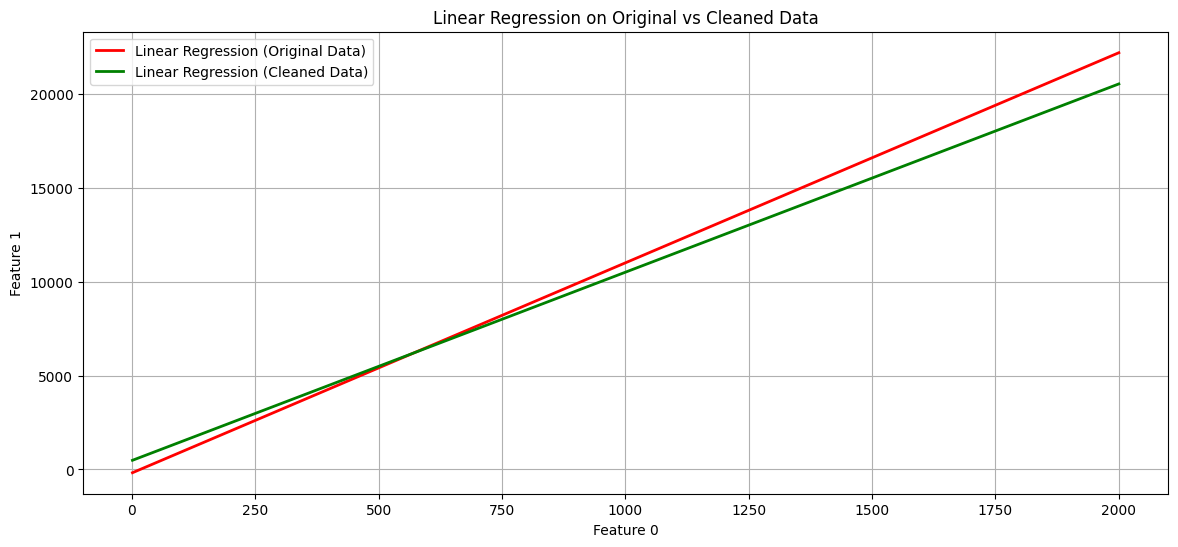

Original Data Model Parameters:
Intercept: -184.4055650325099
Coefficient: [11.18624194]
R² using scikit-learn's score method: 0.4573

Cleaned Data Model Parameters:
Intercept: 478.64081158783665
Coefficient: [10.024261]
R² using scikit-learn's score method: 0.8263


In [158]:
Y_original= df['feature_1'].values # unclean data
Y = df_final['feature_1'] # clean data


# **Fit Linear Regression Models**
# 1. Fit on Original Data (X, Y_original)
reg_original = LinearRegression()
reg_original.fit(X, Y_original)

# 2. Fit on Cleaned Data (X, Y_cleaned)
reg_cleaned = LinearRegression()
reg_cleaned.fit(X, Y)

# **Predictions**
# 1. Predictions on Original Data
Y_pred_original = reg_original.predict(X)

# 2. Predictions on Cleaned Data
Y_pred_cleaned = reg_cleaned.predict(X)

# **Plotting**
plt.figure(figsize=(14, 6))

# Plot original data and predictions
#plt.scatter(X, Y_original, color='black', label='Original Data')
plt.plot(X, Y_pred_original, color='red', label='Linear Regression (Original Data)', linewidth=2)

# Plot cleaned data and predictions
#plt.scatter(X, Y, color='blue', label='Cleaned Data (Y)', alpha=0.6)
plt.plot(X, Y_pred_cleaned, color='green', label='Linear Regression (Cleaned Data)', linewidth=2)

# Add labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Linear Regression on Original vs Cleaned Data')
plt.legend()
plt.grid(True)
plt.show()

# calculating r2 metric with sklearn
r2_originL = reg_original.score(X,Y_original)
r2_cleaned = reg_cleaned.score(X,Y)

# **Print Model Parameters**
print("Original Data Model Parameters:")
print(f"Intercept: {reg_original.intercept_}")
print(f"Coefficient: {reg_original.coef_}")
print(f"R² using scikit-learn's score method: {r2_originL:.4f}")

print("\nCleaned Data Model Parameters:")
print(f"Intercept: {reg_cleaned.intercept_}")
print(f"Coefficient: {reg_cleaned.coef_}")
print(f"R² using scikit-learn's score method: {r2_cleaned:.4f}")

Row 2

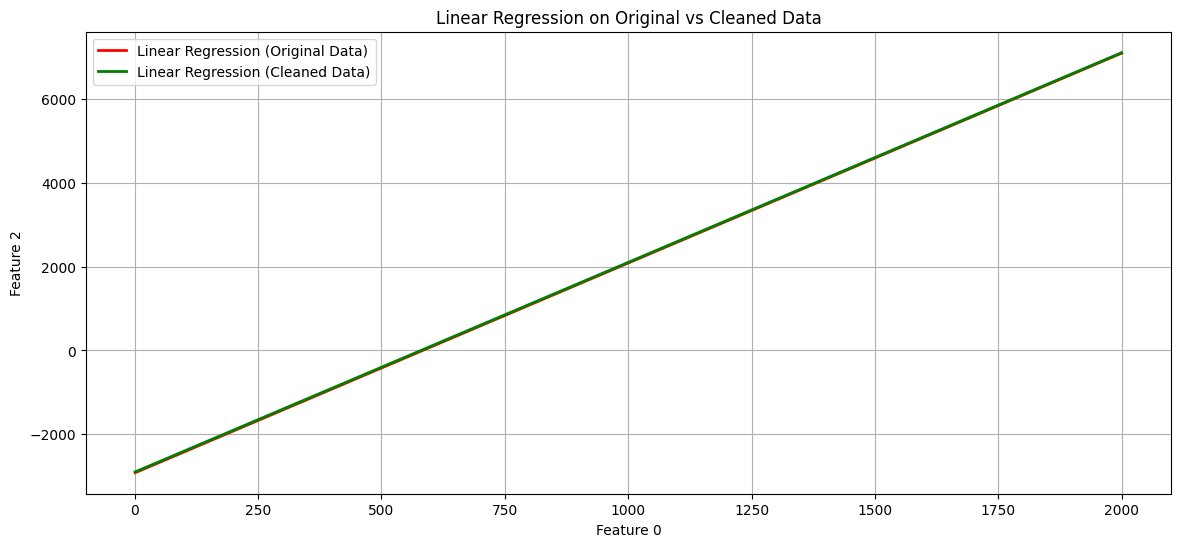

Original Data Model Parameters:
Intercept: -2926.0779144572284
Coefficient: [5.01200741]
R² using scikit-learn's score method: 0.8728

Cleaned Data Model Parameters:
Intercept: -2906.3969150402027
Coefficient: [5.00773711]
R² using scikit-learn's score method: 0.9382


In [159]:
Y_original= df['feature_2'].values # unclean data
Y = df_final_2['feature_2'] # clean data

# **Fit Linear Regression Models**
# 1. Fit on Original Data (X, Y_original)
reg_original = LinearRegression()
reg_original.fit(X, Y_original)

# 2. Fit on Cleaned Data (X, Y_cleaned)
reg_cleaned = LinearRegression()
reg_cleaned.fit(X, Y)

# **Predictions**
# 1. Predictions on Original Data
Y_pred_original = reg_original.predict(X)

# 2. Predictions on Cleaned Data
Y_pred_cleaned = reg_cleaned.predict(X)

# **Plotting**
plt.figure(figsize=(14, 6))

# Plot original data and predictions
#plt.scatter(X, Y_original, color='black', label='Original Data')
plt.plot(X, Y_pred_original, color='red', label='Linear Regression (Original Data)', linewidth=2)

# Plot cleaned data and predictions
#plt.scatter(X, Y, color='blue', label='Cleaned Data (Y)', alpha=0.6)
plt.plot(X, Y_pred_cleaned, color='green', label='Linear Regression (Cleaned Data)', linewidth=2)

# Add labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 2')
plt.title('Linear Regression on Original vs Cleaned Data')
plt.legend()
plt.grid(True)
plt.show()

# calculating r2 metric with sklearn
r2_originL = reg_original.score(X,Y_original)
r2_cleaned = reg_cleaned.score(X,Y)

# **Print Model Parameters**
print("Original Data Model Parameters:")
print(f"Intercept: {reg_original.intercept_}")
print(f"Coefficient: {reg_original.coef_}")
print(f"R² using scikit-learn's score method: {r2_originL:.4f}")

print("\nCleaned Data Model Parameters:")
print(f"Intercept: {reg_cleaned.intercept_}")
print(f"Coefficient: {reg_cleaned.coef_}")
print(f"R² using scikit-learn's score method: {r2_cleaned:.4f}")

Row 3

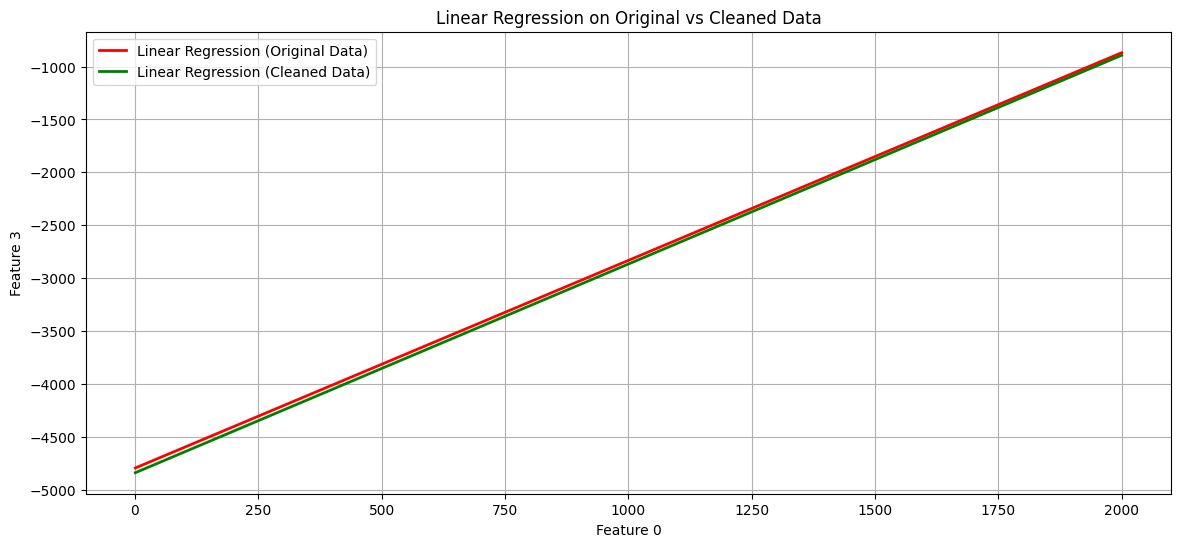

Original Data Model Parameters:
Intercept: -4797.364910955478
Coefficient: [1.96408487]
R² using scikit-learn's score method: 0.4089

Cleaned Data Model Parameters:
Intercept: -4842.126315032341
Coefficient: [1.97453076]
R² using scikit-learn's score method: 0.4964


In [160]:
Y_original= df['feature_3'].values # unclean data
Y = df_final_3['feature_3'] # clean data

# **Fit Linear Regression Models**
# 1. Fit on Original Data (X, Y_original)
reg_original = LinearRegression()
reg_original.fit(X, Y_original)

# 2. Fit on Cleaned Data (X, Y_cleaned)
reg_cleaned = LinearRegression()
reg_cleaned.fit(X, Y)

# **Predictions**
# 1. Predictions on Original Data
Y_pred_original = reg_original.predict(X)

# 2. Predictions on Cleaned Data
Y_pred_cleaned = reg_cleaned.predict(X)

# **Plotting**
plt.figure(figsize=(14, 6))

# Plot original data and predictions
#plt.scatter(X, Y_original, color='black', label='Original Data')
plt.plot(X, Y_pred_original, color='red', label='Linear Regression (Original Data)', linewidth=2)

# Plot cleaned data and predictions
#plt.scatter(X, Y, color='blue', label='Cleaned Data (Y)', alpha=0.6)
plt.plot(X, Y_pred_cleaned, color='green', label='Linear Regression (Cleaned Data)', linewidth=2)

# Add labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 3')
plt.title('Linear Regression on Original vs Cleaned Data')
plt.legend()
plt.grid(True)
plt.show()

# calculating r2 metric with sklearn
r2_originL = reg_original.score(X,Y_original)
r2_cleaned = reg_cleaned.score(X,Y)

# **Print Model Parameters**
print("Original Data Model Parameters:")
print(f"Intercept: {reg_original.intercept_}")
print(f"Coefficient: {reg_original.coef_}")
print(f"R² using scikit-learn's score method: {r2_originL:.4f}")

print("\nCleaned Data Model Parameters:")
print(f"Intercept: {reg_cleaned.intercept_}")
print(f"Coefficient: {reg_cleaned.coef_}")
print(f"R² using scikit-learn's score method: {r2_cleaned:.4f}")

# step 1.5 : Robust regression (two models)

Row 1

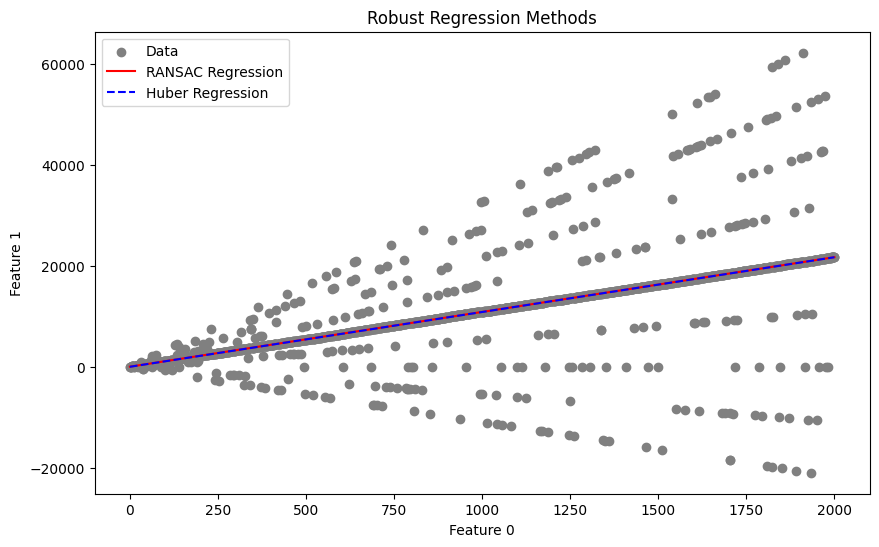

RANSAC MSE: 216775198.2880278
Huber MSE: 216294895.3976593


In [161]:
Y_original= df['feature_1']

# --- RANSAC ---
ransac = RANSACRegressor()
ransac.fit(X, Y_original)
y_pred_ransac = ransac.predict(X)

# --- Huber ---
huber = HuberRegressor()
huber.fit(X, Y_original)
y_pred_huber = huber.predict(X)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(X, Y_original, color='gray', label='Data')
plt.plot(X, y_pred_ransac, color='red', label='RANSAC Regression')
plt.plot(X, y_pred_huber, color='blue',linestyle='--', label='Huber Regression')
plt.legend()
plt.title('Robust Regression Methods')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

# ---  Print metrics ---
print("RANSAC MSE:", mean_squared_error(Y, y_pred_ransac))
print("Huber MSE:", mean_squared_error(Y, y_pred_huber))

Row 2

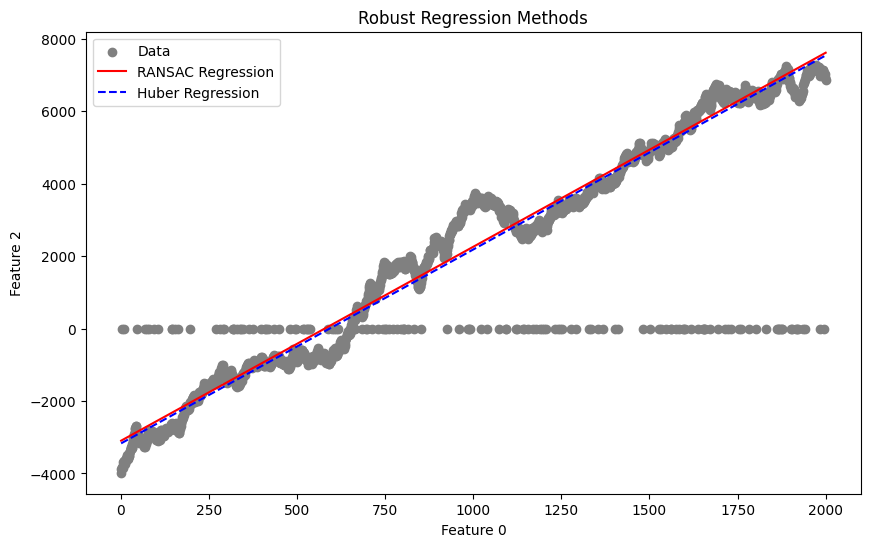

RANSAC MSE: 31426732.5116812
Huber MSE: 30664629.603080437


In [162]:
Y_original= df['feature_2']

# --- RANSAC ---
ransac = RANSACRegressor()
ransac.fit(X, Y_original)
y_pred_ransac = ransac.predict(X)

# --- Huber ---
huber = HuberRegressor()
huber.fit(X, Y_original)
y_pred_huber = huber.predict(X)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(X, Y_original, color='gray', label='Data')
plt.plot(X, y_pred_ransac, color='red', label='RANSAC Regression')
plt.plot(X, y_pred_huber, color='blue',linestyle='--', label='Huber Regression')
plt.legend()
plt.title('Robust Regression Methods')
plt.xlabel('Feature 0')
plt.ylabel('Feature 2')
plt.show()

# ---  Print metrics ---
print("RANSAC MSE:", mean_squared_error(Y, y_pred_ransac))
print("Huber MSE:", mean_squared_error(Y, y_pred_huber))

Row 3

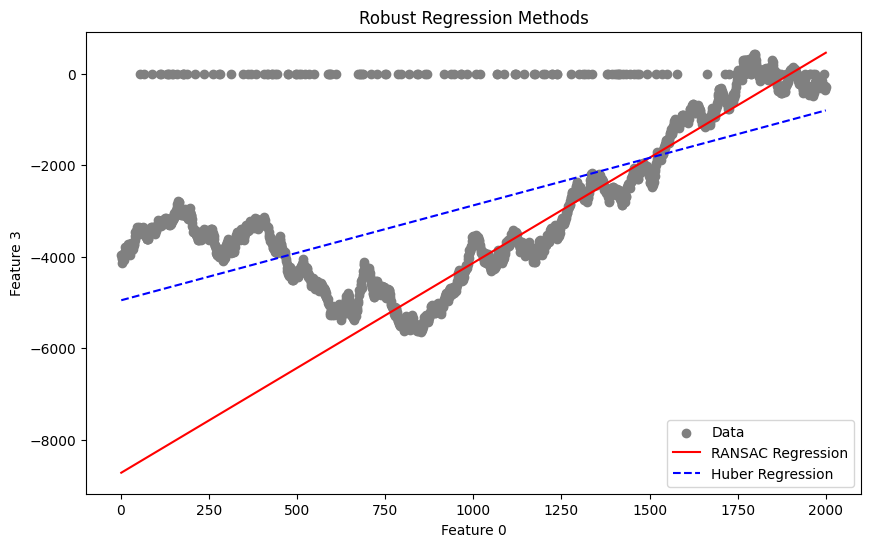

RANSAC MSE: 5204637.588190412
Huber MSE: 1321767.9742167636


In [163]:
Y_original= df['feature_3']

# --- RANSAC ---
ransac = RANSACRegressor()
ransac.fit(X, Y_original)
y_pred_ransac = ransac.predict(X)

# --- Huber ---
huber = HuberRegressor()
huber.fit(X, Y_original)
y_pred_huber = huber.predict(X)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.scatter(X, Y_original, color='gray', label='Data')
plt.plot(X, y_pred_ransac, color='red', label='RANSAC Regression')
plt.plot(X, y_pred_huber, color='blue',linestyle='--', label='Huber Regression')
plt.legend()
plt.title('Robust Regression Methods')
plt.xlabel('Feature 0')
plt.ylabel('Feature 3')
plt.show()

# ---  Print metrics ---
print("RANSAC MSE:", mean_squared_error(Y, y_pred_ransac))
print("Huber MSE:", mean_squared_error(Y, y_pred_huber))

# Section 2 : two dependent variables

# step 2.1 : visualizing the raw data in 3D space

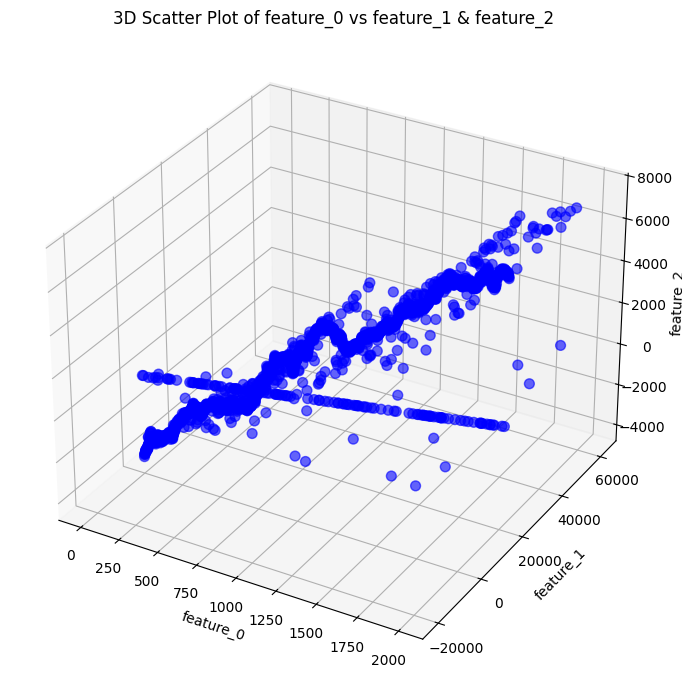

In [164]:
# Preparing data
X = df[['feature_0']].values.flatten()  # X-axis
y1_original = df['feature_1'].values             # Y-axis (target 1)
y2_original = df['feature_2'].values             # Z-axis (target 2)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, y1_original, y2_original, c='blue', s=50, alpha=0.6)

# Labels and aesthetics
ax.set_xlabel('feature_0')
ax.set_ylabel('feature_1')
ax.set_zlabel('feature_2')
ax.set_title('3D Scatter Plot of feature_0 vs feature_1 & feature_2')

plt.tight_layout()
plt.show()

# step 2.2 : visualizing raw and cleaned data together

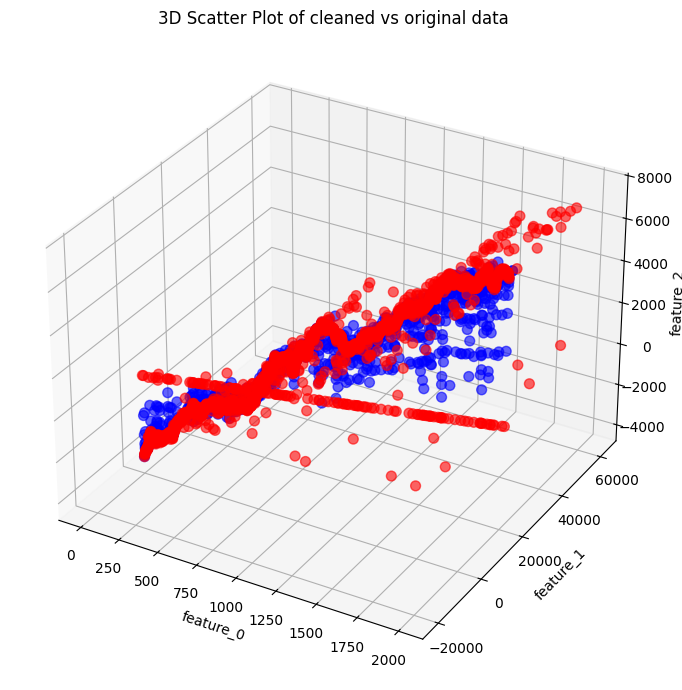

In [165]:
y1 = df_final['feature_1'].values             # Y-axis (target 1)
y2 = df_final_2['feature_2'].values             # Z-axis (target 2)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, y1, y2, c='blue', s=50, alpha=0.6)
ax.scatter(X, y1_original, y2_original, c='red', s=50, alpha=0.6)


# Labels and aesthetics
ax.set_xlabel('feature_0')
ax.set_ylabel('feature_1')
ax.set_zlabel('feature_2')
ax.set_title('3D Scatter Plot of cleaned vs original data')

plt.tight_layout()
plt.show()

# step 2.3 : Linear regression from scratch

**Defining two variable regression models**

In [166]:
class LinearRegressionMultivariateMSE:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_targets = y.shape[1]

        self.weights = np.zeros((n_features, n_targets))  # now a matrix
        self.bias = np.zeros(n_targets)  # one bias per output dimension

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias  # shape: (n_samples, n_targets)
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))  # shape: (n_features, n_targets)
            db = (1 / n_samples) * np.sum(y_pred - y, axis=0)  # shape: (n_targets,)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


class LinearRegressionMultivariateMAE:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_targets = y.shape[1]

        self.weights = np.zeros((n_features, n_targets))
        self.bias = np.zeros(n_targets)

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            error = y_pred - y

            # Gradient of MAE is the sign of the error
            dw = (1 / n_samples) * np.dot(X.T, np.sign(error))
            db = (1 / n_samples) * np.sum(np.sign(error), axis=0)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

**Applying and visualizing**

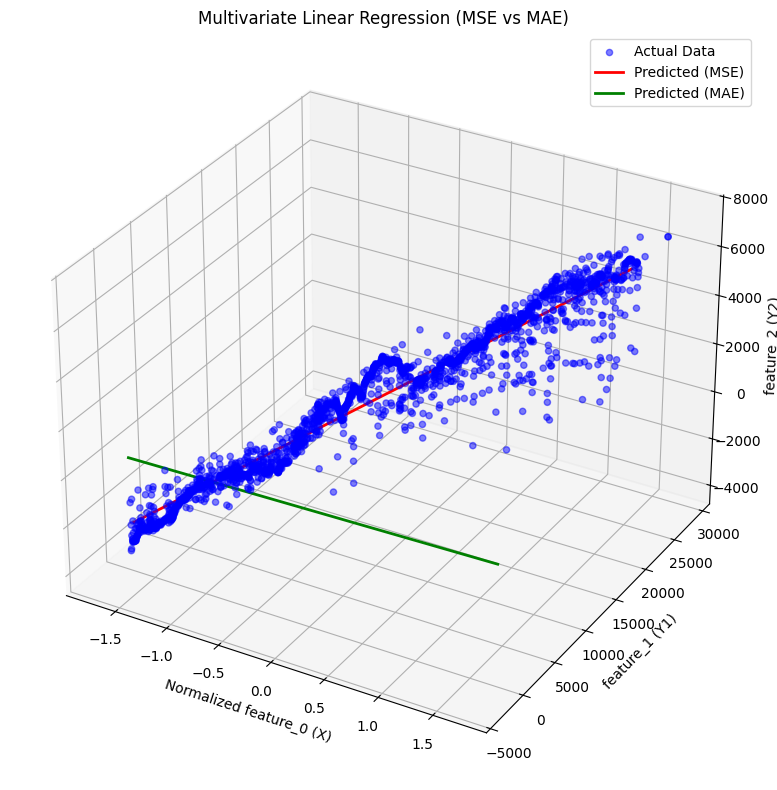

In [167]:
# Inputs: feature_0 as independent, feature_1 and feature_2 as dependent
X = df[['feature_0']].values
y = np.column_stack((y1, y2))

# Normalize input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------- MSE Model --------
model_mse = LinearRegressionMultivariateMSE(lr=0.1, n_iters=1000)
model_mse.fit(X_scaled, y)
preds_mse = model_mse.predict(X_scaled)

# -------- MAE Model --------
model_mae = LinearRegressionMultivariateMAE(lr=0.1, n_iters=1000)
model_mae.fit(X_scaled, y)
preds_mae = model_mae.predict(X_scaled)

# Prepare data
x_vals = X_scaled.flatten()
y1_actual = y[:, 0]
y2_actual = y[:, 1]
y1_pred_mse = preds_mse[:, 0]
y2_pred_mse = preds_mse[:, 1]
y1_pred_mae = preds_mae[:, 0]
y2_pred_mae = preds_mae[:, 1]

# -------- 3D Plot --------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Actual data
ax.scatter(x_vals, y1_actual, y2_actual, c='blue', label='Actual Data', alpha=0.5)

# Predicted (MSE)
ax.plot(x_vals, y1_pred_mse, y2_pred_mse, color='red', label='Predicted (MSE)', linewidth=2)

# Predicted (MAE)
ax.plot(x_vals, y1_pred_mae, y2_pred_mae, color='green', label='Predicted (MAE)', linewidth=2)

# Labels
ax.set_xlabel('Normalized feature_0 (X)')
ax.set_ylabel('feature_1 (Y1)')
ax.set_zlabel('feature_2 (Y2)')
ax.set_title('Multivariate Linear Regression (MSE vs MAE)')
ax.legend()
plt.tight_layout()
plt.show()

# step 2.4 : LinearRegression() from sklearn

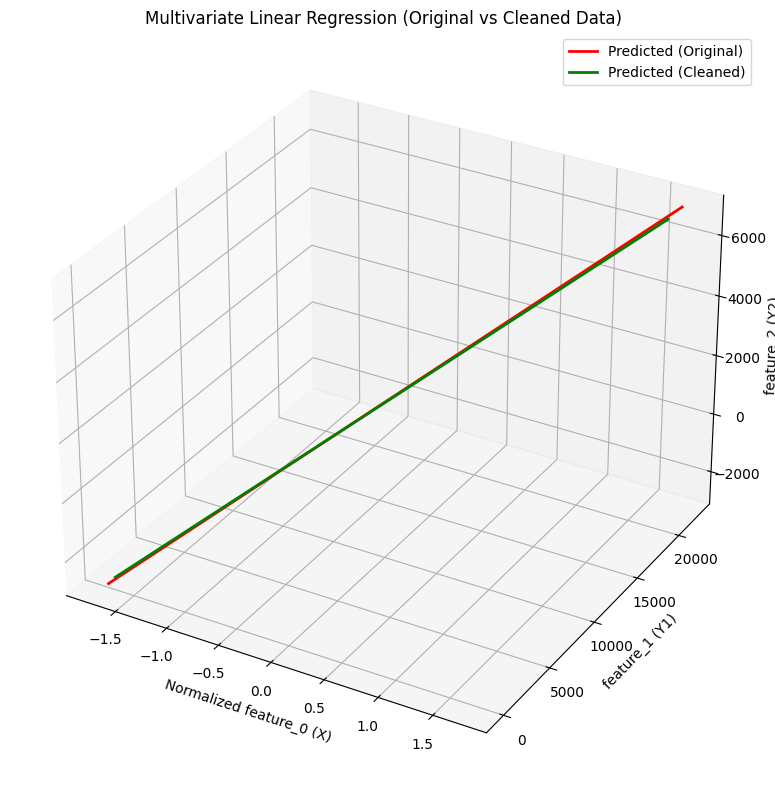

In [168]:
y1_original= df['feature_1'].values # unclean value of y1
y2_original= df['feature_2'].values # unclean value of y2

y_original = np.column_stack((y1_original, y2_original))

# **Fit Linear Regression Models**
# 1. Fit on Original Data (X, Y_original)
reg_original = LinearRegression()
reg_original.fit(X_scaled, y_original)

# 2. Fit on Cleaned Data (X, Y_cleaned)
reg_cleaned = LinearRegression()
reg_cleaned.fit(X_scaled, y)

# **Predictions**
# 1. Predictions on Original Data
Y_pred_original = reg_original.predict(X_scaled)

# 2. Predictions on Cleaned Data
Y_pred_cleaned = reg_cleaned.predict(X_scaled)

# Prepare data for plotting
x_vals = X_scaled.flatten()
y1_actual = y_original[:, 0]
y2_actual = y_original[:, 1]
y1_cleaned = y[:, 0]
y2_cleaned = y[:, 1]
y1_pred_original = Y_pred_original[:, 0]
y2_pred_original = Y_pred_original[:, 1]
y1_pred_cleaned = Y_pred_cleaned[:, 0]
y2_pred_cleaned = Y_pred_cleaned[:, 1]

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Actual Data (Original)
#ax.scatter(x_vals, y1_actual, y2_actual, c='red', label='Actual Data (Original)', alpha=0.6)

# Plot Actual Data (Clean)
#ax.scatter(x_vals, y1_cleaned, y2_cleaned, c='pink', label='Actual Data (clear)', alpha=0.6)

# Plot Predicted Data (Original)
ax.plot(x_vals, y1_pred_original, y2_pred_original, color='red', label='Predicted (Original)', linewidth=2)

# Plot Predicted Data (Cleaned)
ax.plot(x_vals, y1_pred_cleaned, y2_pred_cleaned, color='green', label='Predicted (Cleaned)', linewidth=2)

# Labels
ax.set_xlabel('Normalized feature_0 (X)')
ax.set_ylabel('feature_1 (Y1)')
ax.set_zlabel('feature_2 (Y2)')
ax.set_title('Multivariate Linear Regression (Original vs Cleaned Data)')
ax.legend()

plt.tight_layout()
plt.show()

# step 2.5 : Robust regression (two models)

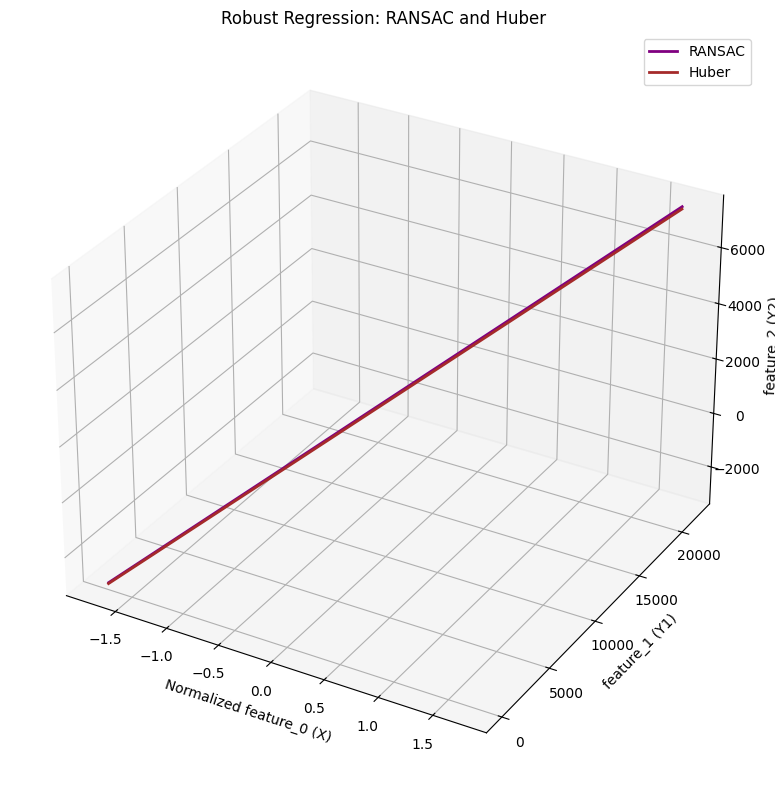

In [169]:
# Prepare individual targets
y1 = y_original[:, 0]  # feature_1
y2 = y_original[:, 1]  # feature_2

# --- RANSAC for each output ---
ransac1 = RANSACRegressor()
ransac1.fit(X_scaled, y1)
y1_pred_ransac = ransac1.predict(X_scaled)

ransac2 = RANSACRegressor()
ransac2.fit(X_scaled, y2)
y2_pred_ransac = ransac2.predict(X_scaled)

# --- Huber for each output ---
huber1 = HuberRegressor()
huber1.fit(X_scaled, y1)
y1_pred_huber = huber1.predict(X_scaled)

huber2 = HuberRegressor()
huber2.fit(X_scaled, y2)
y2_pred_huber = huber2.predict(X_scaled)

Y_pred_ransac = np.column_stack((y1_pred_ransac, y2_pred_ransac))
Y_pred_huber = np.column_stack((y1_pred_huber, y2_pred_huber))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot predicted lines
ax.plot(x_vals, y1_pred_ransac, y2_pred_ransac, color='purple', label='RANSAC', linewidth=2)
ax.plot(x_vals, y1_pred_huber, y2_pred_huber, color='brown', label='Huber', linewidth=2)

ax.set_xlabel('Normalized feature_0 (X)')
ax.set_ylabel('feature_1 (Y1)')
ax.set_zlabel('feature_2 (Y2)')
ax.set_title('Robust Regression: RANSAC and Huber')
ax.legend()

plt.tight_layout()
plt.show()